In [2]:
!pip install matplotlib
!pip install numpy 
!pip install pmdarima

In [6]:
# Basic setup 
# Forcasting iShares Core U.S. Aggregate Bond ETF
# index tracks all US IG bonds 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas_datareader as web
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression

# Define data sources and time range
start = '2018-01-01'
end = '2024-01-01'

# Fetching yield data (10-year Treasury yield)
yield_10yr = web.DataReader('GS10', 'fred', start, end)

# Fetching rates data (Effective Federal Funds Rate)
rates = web.DataReader('EFFR', 'fred', start, end)

# Fetching AGG ETF closing prices
bond = 'AGG'
bond_df = yf.download(bond, start=start, end=end)

# Combine datasets into a single DataFrame
data_df = pd.concat([bond_df['Close'], yield_10yr, rates], axis=1)
data_df.columns = ['Close', 'Yield_10yr', 'EFFR']
data_df.dropna(inplace=True)

# Split data into training and testing sets (80% train, 20% test)
train, test = train_test_split(data_df, test_size=0.2, shuffle=False)


[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=160.546, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=467.817, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=160.180, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=159.475, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=154.831, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=205.314, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=154.351, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=236.870, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=153.964, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=153.103, Time=0.02 sec
 A

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


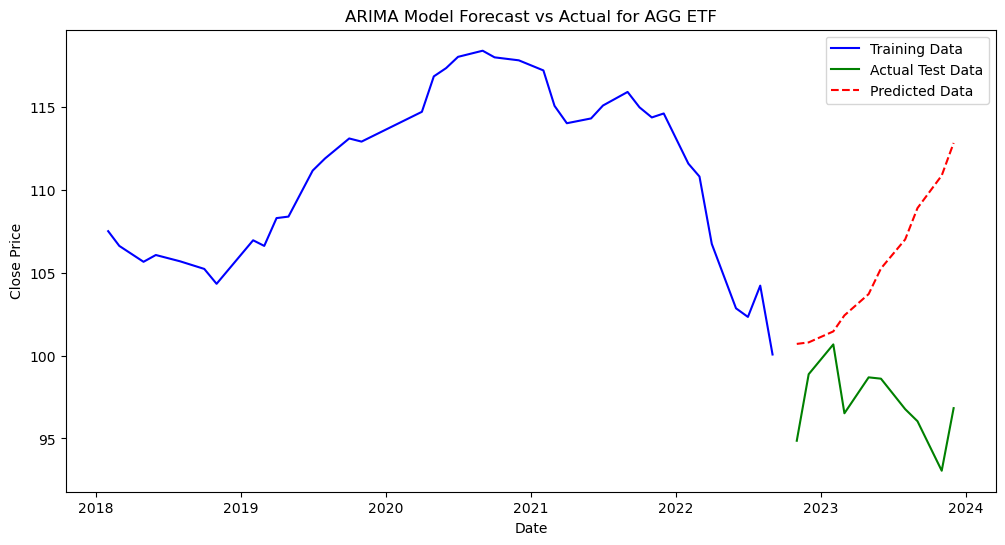

In [4]:
# ARIMA MODEL
# multivariant times series forcasting with ARIMA 
# following https://www.youtube.com/watch?v=nDhiNwVH7yM&ab_channel=Kalso for inspo 
# ARIMA - autorgregssive integrated moving average
# using rates and to predict IG bond prices of the ETF 

# p, d, q in model will be tuned for accurate results 
# p - autoregression, using past to predict future. This plot shows how much each past value affects the current value.
# d - differencing (keep subtracting ech value with previous one until it's stable)
# q - moving average (patterns in errors from past forecasts)

# Use auto_arima to automatically determine ARIMA parameters (p, d, q)
model_auto = auto_arima(
    train['Close'],
    exogenous=train[['Yield_10yr', 'EFFR']],
    seasonal=False,
    stepwise=True,
    trace=True
)
print(model_auto.summary())

# Forecast using the ARIMA model
predictions = model_auto.predict(n_periods=len(test), exogenous=test[['Yield_10yr', 'EFFR']])

# Evaluate model performance - lower error is better 
mse = mean_squared_error(test['Close'], predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue', linestyle='-')

# Plot actual test data
plt.plot(test.index, test['Close'], label='Actual Test Data', color='green', linestyle='-')

# Plot predicted test data
plt.plot(test.index, predictions, label='Predicted Data', color='red', linestyle='--')

# Add titles and labels
plt.title("ARIMA Model Forecast vs Actual for AGG ETF")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Linear Regression Mean Squared Error: 5.4153871828958895


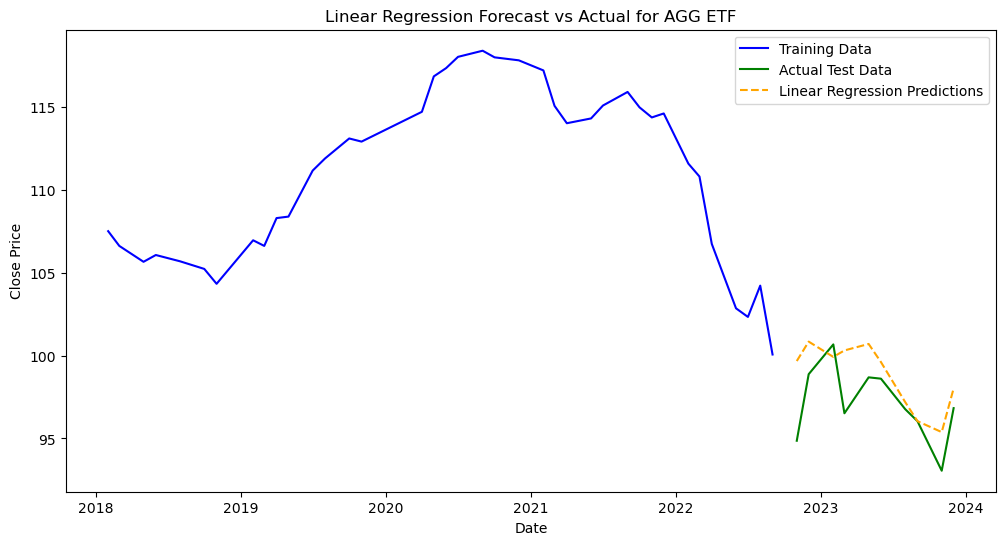

In [7]:
# Linear regression  
# Train the Linear Regression model (using two factors - finding beta) 
lr_model = LinearRegression()
lr_model.fit(train[['Yield_10yr', 'EFFR']], train['Close'])

# Make predictions for the test set
test['LR_Predictions'] = lr_model.predict(test[['Yield_10yr', 'EFFR']])

# Calculate performance metrics for Linear Regression - lower number better 
lr_mse = mean_squared_error(test['Close'], test['LR_Predictions'])
print(f"Linear Regression Mean Squared Error: {lr_mse}")

# Plotting 
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='blue', linestyle='-')

# Plot actual test data (real results)
plt.plot(test.index, test['Close'], label='Actual Test Data', color='green', linestyle='-')

# Plot Linear Regression predictions
plt.plot(test.index, test['LR_Predictions'], label='Linear Regression Predictions', color='orange', linestyle='--')

plt.title("Linear Regression Forecast vs Actual for AGG ETF")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()